# <font color="blue"> Evaluate Risks of Natural Hazards in California in the Context of Growing Population and Rising Housing Costs </font>

## <font color="blue"> Notebook Outline:<font>
- [Introduction](#intro)
- [Setup](#setup)
- [Part-1: Analyze Population, Single Family Homes Cost and the Risk of Natural Disasters for California (CA) Counties](#part1)
    - [Read CA County GeoJSON Data](#ca_geo)
    - [Read and analyze CA Median Prices of Single Family Homes from 1990 to 2024 Data](#home_price)
    - [Read and analyze CA Population and Housing Units from 1990 to 2020 Data](#pop)
    - [Read and analyze FEMA Natural Hazard Risk Index for CA Counties Data](#fema)
    - [Perform Spatial Analysis of Population, Housing and FEMA Risk Index](#spatial)
    - [Perform Statistical Analysis of Population, Housing and FEMA Risk Index](#stats)
- [Part-2: What-If Scenario. Estimate Single Family Homes Financial Loss if the Loma Prieta Earthquake Were to Happen Today](#part2)
- [Conclusion](#conclusion)

<a id='intro'></a>
## <font color="blue"> Introduction </font>

California has seen following uptrends in recent decades:

1. Increase in real estate prices.
2. Increase in population.
3. Increase in risk of natural hazards.
    - Several regions in California are prone to major earthquakes. Longer a region goes without an earthquake, the probability of a big one increases.
    - Natural hazards such as wildfires are expected to increase with the warming climate.
 
A natural question that arises is whether regions experiencing the highest population growth and rising housing costs are also the ones most vulnerable to natural disasters. Part 1 of this project addresses this question by examining home prices, population trends, and the FEMA Risk Index across California counties. This analysis is conducted both spatially and statistically. Although housing includes various types—such as single-family, multi-family, and mobile homes—this project focuses solely on single-family homes for simplicity.

Given that both housing costs and natural disaster risks are increasing over time, it is reasonable to assume that the potential financial losses from such disasters will also rise—even if the severity of the events remains unchanged. For instance, would the economic impact be greater if a past earthquake occurred today? Part 2 of the project explores this “what-if” scenario by estimating the potential financial loss to single-family homes if the 1989 Loma Prieta earthquake, a magnitude 6.9 event, were to strike the San Francisco Bay Area today.

<a id='setup'></a>
## <font color="blue"> Setup </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sb
import ipywidgets as widgets
from ipywidgets import interact
from geopandas import GeoSeries, GeoDataFrame, read_file, gpd
import os
import warnings
warnings.filterwarnings('ignore')

<a id='part1'></a>
## <font color="blue"> Part-1: Analyze Population, Single Family Housing Cost and the Risk of Natural Disasters. </font>
Are areas with the highest population growth and increased housing costs also the areas at the highest risk from natural disasters?
***

<a id='ca_geo'></a>
### <font color="blue">California County GeoJSON Data</font>

First, read in the CA county GeoJSON data which is used to plot the maps in this notebook.

#### <font color="purple"> Dataset: GeoJSON dataset for all US Counties available from Plotly was downloaded from the link [here](https://github.com/plotly/datasets/blob/master/geojson-counties-fips.json).</font>

***

In [2]:
# Read the US County GeoJSON data
us_county = gpd.read_file("../datasets/geojson/geojson-counties-fips.json")
us_county.head(3)

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,01001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.71790 32.402..."
1,01009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.57780 33.76532, -86.75914 33.840..."
2,01017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87053, -85.12342 32.772..."


In [3]:
# Filter California counties as identified by STATE = 06
# Since we are intereseted only the geometry info for each county, drop all other columns
ca_county = us_county[us_county["STATE"] == "06"]
ca_county.reset_index(inplace = True)
ca_county.drop(["index", "id", "GEO_ID", "STATE", "COUNTY", "LSAD", "CENSUSAREA"], axis = 1, inplace = True)
ca_county.columns = ["county", "geometry"]
ca_county.set_index("county", inplace = True)
ca_county.head(3)

,geometry
county,
Amador,"POLYGON ((-120.99550 38.22541, -121.02708 38.3..."
Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7..."
Lake,"POLYGON ((-122.62740 38.66751, -122.82159 38.8..."


<AxesSubplot:>

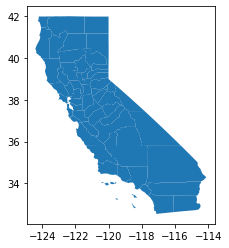

In [4]:
# Verify that we have correct geometry for all California counties by plotting them
ca_county.plot()

**<font color="purple"><font size=3> Above plot confirms that we have read in the correct geometry for all CA counties. </font>**

***

<a id='home_price'></a>
### <font color="blue">California Median Prices of Single Family Homes from 1990 to 2024</font>

#### <font color="purple"> Dataset: Median Prices of Existing Single Family Homes available from California Assosciation of Realtors was downloaded from the link [here](https://www.car.org/marketdata/data/housingdata).
    
* This dataset contains monthly median prices for single family homes for the years 1990-2024 for counties in California.
* It also contains median single family home prices for the entire state of the California and some of its metro areas.
* Data is not available for some California counties but these are in less populated, remote areas and should not affect the analysis done in this project. 

***

In [5]:
# Read in the California Single Famility Home Median Home Prices data
# Skip first 6 rows since they do not contain the home sale data and header is on line 1
ca_home_prices = pd.read_csv("../datasets/realEstate/CA/MedianPricesofExistingDetachedHomesHistoricalData(Median Price).csv",
                             skiprows=6, engine="python", header=1)

# drop columns with all NaN and replace NaNs in others
ca_home_prices.dropna(axis = 'columns', inplace=True, how="all")
ca_home_prices.fillna(0, inplace=True)

ca_home_prices.head(3)

,Mon-Yr,CA,Alameda,Amador,Butte,Calaveras,Contra-Costa,Del Norte,El Dorado,Fresno,...,Yolo,Yuba,Condo,LA Metro,Central Coast,Central Valley,Far North,Inland Empire,S.F. Bay Area,SoCal
0,Jan-90,"$194,952","$226,149",0,"$102,143",0,0,0,0,"$82,083",...,0,0,"$141,519","$203,390",0,0,0,0,"$227,366",0
1,Feb-90,"$196,273","$219,306",0,"$83,333",0,0,0,0,"$87,187",...,0,0,"$144,965","$211,024",0,0,0,0,"$234,739",0
2,Mar-90,"$194,856","$225,162",0,"$100,000",0,0,0,0,"$83,889",...,0,0,"$141,132","$209,286",0,0,0,0,"$235,337",0


In [6]:
# to_datetime automatically converts years 90-99 to 1990-1999 and years 00 and later to 2000 and later
ca_home_prices['Date'] = pd.to_datetime(ca_home_prices['Mon-Yr'], format='%b-%y')
ca_home_prices.set_index("Date", inplace = True)
ca_home_prices.drop(["Mon-Yr"], axis=1, inplace=True)

# Replace "-" in column names e.g. replace Contra-Costa with Contra Costa to match how the name appears in the county GeoJson
ca_home_prices.columns = ca_home_prices.columns.str.replace('-', ' ')

# Convert the home sale values that are strings to int
ca_home_prices = ca_home_prices.applymap(lambda x: int(x.replace('$', '').replace(',', '')) if isinstance(x, str) else x)

ca_home_prices.head(3)

,CA,Alameda,Amador,Butte,Calaveras,Contra Costa,Del Norte,El Dorado,Fresno,Glenn,...,Yolo,Yuba,Condo,LA Metro,Central Coast,Central Valley,Far North,Inland Empire,S.F. Bay Area,SoCal
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,194952,226149,0,102143,0,0,0,0,82083,0,...,0,0,141519,203390,0,0,0,0,227366,0
1990-02-01,196273,219306,0,83333,0,0,0,0,87187,0,...,0,0,144965,211024,0,0,0,0,234739,0
1990-03-01,194856,225162,0,100000,0,0,0,0,83889,0,...,0,0,141132,209286,0,0,0,0,235337,0


In [7]:
# Since this is a monthly data, group it by years
ca_home_prices["Year"] = ca_home_prices.index.year
yearly_ca_home_prices = ca_home_prices.groupby("Year")
yearly_ca_home_prices.mean().index

Int64Index([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
            2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
            2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
            2023, 2024],
           dtype='int64', name='Year')

#### <font color="blue"> How has the CA Median Prices of Single Family Homes changed from 1990-2024? </font>

In [8]:
# plot yearly averages for median home prices
# use the widget to select the county of interest
col_list = [i for i in list(ca_home_prices.columns) if i not in "Year"]
menu = widgets.Dropdown(options = col_list, value = 'CA', description = 'Select a California County or a Metro Area:')
menu.layout.width = '500px'
menu.style.description_width = 'initial'

def show_bar_plot(option):
    title = "Yearly Average of Median Home Sale Price for Single Family Homes in the Region " + option
    plt.figure(figsize=(40, 10)) 
    yearly_ca_home_prices[option].mean().plot(kind = "bar")
    plt.xlabel("Year", fontsize=30)
    plt.ylabel("Average Median Home Price", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.title(title, fontsize=40)
    ax = plt.axes()
    # Display values as currency
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.2f}'))
    plt.grid(True, alpha=0.5)
    plt.show();
    

interact(show_bar_plot, option=menu)

interactive(children=(Dropdown(description='Select a California County or a Metro Area:', layout=Layout(width=…

<function __main__.show_bar_plot(option)>

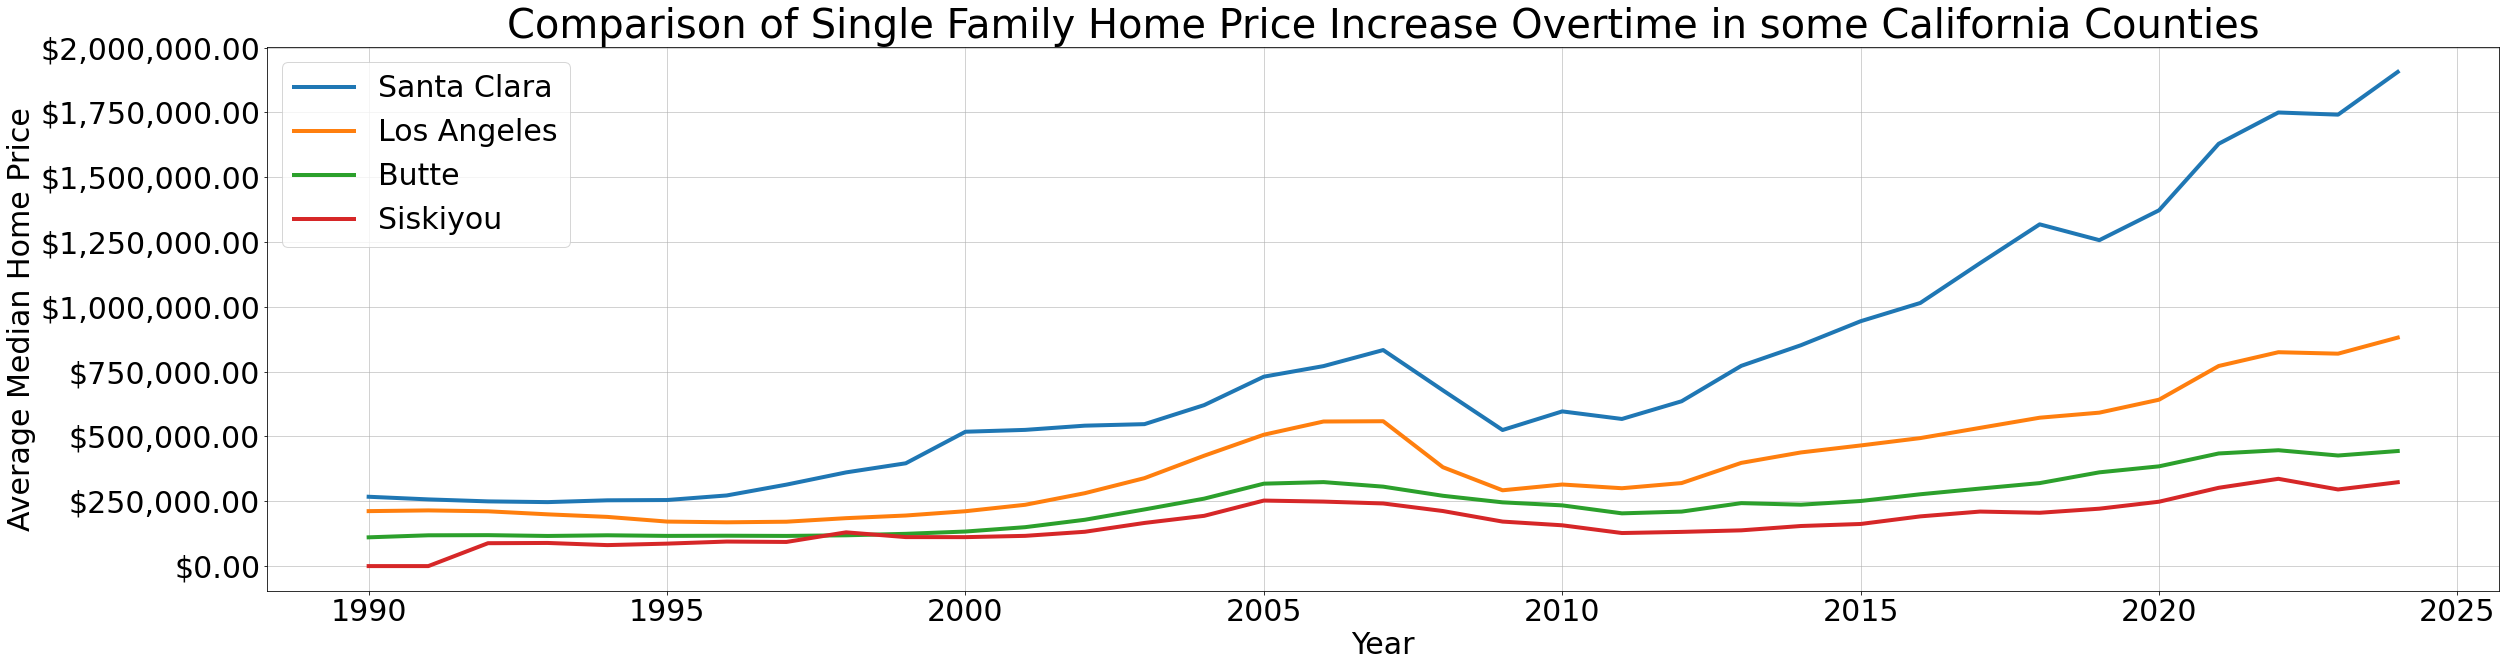

In [9]:
# Plot median home prices for some counties for side by side comparison of how the prices have changed over the years
plt.figure(figsize=(40, 10))
yearly_mean = yearly_ca_home_prices.mean()
for col in ["Santa Clara", "Los Angeles", "Butte", "Siskiyou"]:
    plt.plot(yearly_mean.index, yearly_mean[col], label=col, linewidth=4)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax = plt.axes()
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.2f}'))
plt.title("Comparison of Single Family Home Price Increase Overtime in some California Counties", fontsize=40)
plt.xlabel("Year", fontsize=30)
plt.ylabel("Average Median Home Price", fontsize=30)
plt.legend(fontsize=30)
plt.grid(True, alpha=0.7)

**<font color="purple"> <font size = 3> Above plots show steady increase in single family home prices across California from 1990 to 2024 with some counties showing more significant increase in recent years. This confirms the statement made in the introduction that home prices in Califronia has increased in recent decades. </font>**

#### <font color="blue"> Spatial Analysis: Which CA counties have highest home prices currently? </font>

In [10]:
# We select the latest year home price data and 
# process it so that it is in a form suitable for adding it to the ca_county dataframe
latest_home_prices = yearly_ca_home_prices.mean()[-1:].transpose()
latest_home_prices.reset_index(inplace = True)
latest_home_prices.columns = ["county", "home price"]
latest_home_prices.set_index("county", inplace = True)
latest_home_price_year = yearly_ca_home_prices.mean().index[-1]
latest_home_prices.head()

,home price
county,
CA,8.674600e+05
Alameda,1.291622e+06
Amador,4.332083e+05
Butte,4.438375e+05
Calaveras,4.753958e+05


In [11]:
# Data for metro regions will be automatically dropped and only county specific data will be retained
ca_county["home price"] = latest_home_prices["home price"]
ca_county.head()

,geometry,home price
county,,
Amador,"POLYGON ((-120.99550 38.22541, -121.02708 38.3...",433208.333333
Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7...",352187.500000
Lake,"POLYGON ((-122.62740 38.66751, -122.82159 38.8...",339725.000000
Mariposa,"POLYGON ((-120.38767 37.63336, -120.38733 37.6...",437333.333333
Napa,"POLYGON ((-122.10328 38.51335, -122.08884 38.3...",936500.000000


In [12]:
# Helper functions to plot one or more of ca_county data on a map
# These functions expect their callers to pass the metadata of the information to be plotted in form of a dictionary
def plot_one_data(column_dict, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(20,10))
    col = column_dict["col"]
    ca_county.plot(ax=ax)
    if "missing_data" in column_dict:
        # Some counties do not have values for this column. Display them in lightgrey color.
        ca_county.plot(ax=ax, column=col, legend=True, missing_kwds={'color': 'lightgrey'}, edgecolor = "black", cmap="coolwarm",
                       scheme="quantiles", k=4)
    else:
        ca_county.plot(ax=ax, column=col, legend=True, edgecolor = "black", cmap="coolwarm", scheme="quantiles", k=4)
    ax.set_title(column_dict["title"], fontsize=20, family="serif")
    ax.set_xlabel("Longitude", fontsize=15, family="serif")
    ax.set_ylabel("Latitude", fontsize=15, family="serif")
    ax.grid(alpha = 0.3)
    # Display names of the county based on the threshold e.g. display names of counties that have median home prices above the
    # specified threshold
    ca_county[ca_county[col] > column_dict["threshold"]].apply(lambda row: ax.text(row["geometry"].centroid.coords[0][0], 
                                                                                   row["geometry"].centroid.coords[0][1], 
                                                                                   row.name, fontsize=10, ha='right',
                                                                                   family="serif",
                                                                                   color='black'), axis=1)
def plot_many_data(columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(20,10))
    for i in range(len(columns)):
        plot_one_data(columns[i], axes[i])
    plt.tight_layout()
    plt.show();



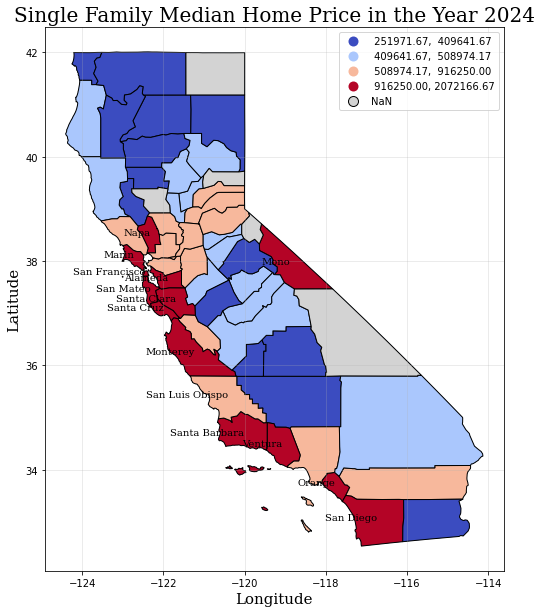

In [13]:
# Pass the metadata of the plot we want in form of a dictionary as expected by the above plot functions

# Threshold decides names of which counties will be displayed
# Home price data has price missing for some counties hence missing_data is set to True for this. These counties will be displayed
# differently by the helper function.
price_plot = {"col" : "home price", "title" : "Single Family Median Home Price in the Year " + str(latest_home_price_year),
              "threshold" : 900000, "missing_data" : True}

plot_one_data(price_plot)

**<font color="purple"> <font size = 3> Above choropleth map uses "quantiles" scheme with number of bins (k) set to 4. Note the counties with red color are in the upper quartile with median home prices ranging from around \\$900,000 to $2,000,000. We will compare this map with the map of FEMA natural hazard risk index score later in the notebook. </font>**
    
***

<a id='pop'></a>
### <font color="blue"> California Population and Housing Units from 1990 to 2020 </font>

#### <font color="purple"> Dataset: Population and Housing Unit Data from the State of California Department of Finance (1990-2020) was downloaded from the links below:</font>
- [Historical Population and Housing Estimates 2010-2020](https://dof.ca.gov/forecasting/demographics/estimates/estimates-e8-2010-2020/)
- [Historical Population and Housing Estimates 2000-2010](https://dof.ca.gov/forecasting/demographics/estimates/estimates-e8-2000-2010/) 
- [Historical Population and Housing Estimates 1990-2000](https://dof.ca.gov/forecasting/demographics/estimates/e-8-historical-population-and-housing-estimates-for-cities-counties-and-the-state-1990-2000/)

**Data Description:**
* Population: Total population and various other data such as number of persons living in occupied housing units, non-household population.
* Housing: Total housing units, number of single family units, and numbers for other types of housing units such as multiple family dwelling units, mobile homes and so on.
* The above data is available for each California county.
* More information on the data is available at the above links.
* **<font color="purple">This project uses the total population and total number of single family units data for each California county.</font>**

***

In [14]:
# Helper function to clean data and return two dataframes: population and single family housing units
def clean_data(df, fix_county_names = True):
    if fix_county_names:
        # County info is split, set it correctly
        df["county_info"] = df["county"].shift(-1)
        df["county"] = df["county"] + " " + df["county_info"]
        df.drop(["county_info"], inplace=True, axis=1)
        # Fill the NaNs in county column with names of the last seen county
        df["county"] = df["county"].fillna(method="ffill")

    # Keep only county totals 
    df = df[df["county"].str.contains("Total", na=False)]
    df.reset_index(inplace=True)
    
    housing = df[["county", "date", "single family housing units"]]
    df.drop(["index", "single family housing units"], inplace=True, axis=1)
    
    # Pivot the data so that each county becomes a column instead of row
    df = df.pivot(index='date', columns='county', values='population')
    df.reset_index(inplace=True)
    df.drop(index=[0], inplace=True)
    df.columns.name = None
    
    # Pivot the data so that each county becomes a column instead of row
    housing = housing.pivot(index='date', columns='county', values='single family housing units')
    housing.reset_index(inplace=True)
    housing.drop(index=[0], inplace=True)
    housing.columns.name = None
    
    df["date"] = pd.to_datetime(df['date'], errors='coerce')
    df.sort_values(by='date', inplace=True)
    df.set_index("date", inplace = True)
    
    housing["date"] = pd.to_datetime(housing['date'], errors='coerce')
    housing.sort_values(by='date', inplace=True)
    housing.set_index("date", inplace = True)
    
    # Convert values from strings to int
    df = df.applymap(lambda x: int(x.replace(',', '')) if isinstance(x, str) else x)
    housing = housing.applymap(lambda x: int(x.replace(',', '')) if isinstance(x, str) else x)
    
    # Keep only the name of the county or name of the state. Remove other info in that string.  
    df = df.rename(columns=lambda x: x.replace("County Total", "") if "County Total" in x else x)
    df = df.rename(columns=lambda x: x.replace("State Total", "") if "State Total" in x else x)
    df = df.rename(columns=lambda x: x.strip())
    
    housing = housing.rename(columns=lambda x: x.replace("County Total", "") if "County Total" in x else x)
    housing = housing.rename(columns=lambda x: x.replace("State Total", "") if "State Total" in x else x)
    housing = housing.rename(columns=lambda x: x.strip())
    
    return df, housing

In [15]:
# Read 1990-2000 population and housing units dataset, skip extra rows and columns
ca_pop_90 = pd.read_csv("../datasets/populationAndHousing/CA/E-8_90-00main.xlsx - EOC State County City by Year.csv",
                        skiprows=[0,1,3], engine="python", usecols=[0,1,2,6])
ca_pop_90.columns = ["county", "date", "population", "single family housing units"]
ca_pop_90.head(3)

,county,date,population,single family housing units
0,California,4/1/1990,"6,145,288","1,746,229"
1,Balance of State,1/1/1991,"6,201,182","1,767,398"
2,NaN,1/1/1992,"6,100,236","1,733,716"


In [16]:
ca_pop_90, ca_housing_90 = clean_data(ca_pop_90)
ca_pop_90.head(3)

,Alameda,Alpine,Amador,Butte,Calaveras,California,Colusa,Contra Costa,Del Norte,El Dorado,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
date,,,,,,,,,,,,,,,,,,,,,
1990-04-01,1276702,1113,30039,182120,31998,29758213,16275,803732,23460,125995,...,388222,370522,64415,49625,13063,311921,48456,669016,141210,58228
1991-01-01,1284782,1107,31049,185393,33480,30143555,16497,814985,25488,130181,...,394070,380858,66159,50730,13059,318460,49562,673051,143825,59352
1992-01-01,1302709,1126,31908,189133,35216,30722998,16838,832229,26915,134898,...,402835,392727,68597,52184,13173,327996,50756,681632,147212,60728


In [17]:
# Read 2000-2010 population and housing units dataset, skip extra rows and columns
ca_pop_00 = pd.read_csv("../datasets/populationAndHousing/CA/Closed_E8_Full_Decade_Final_v2.xlsx - EOC State County City by Year.csv",
                      skiprows=[0,1], engine="python", usecols=[0,1,2,6])
ca_pop_00.columns = ["county", "date", "population", "single family housing units"]

# San Francisco county does not have multiple cities so needs special handling 
sf_index = ca_pop_00[ca_pop_00["county"] == "San Francisco"].index[1]
ca_pop_00.loc[sf_index, "county"] = "County Total"

ca_pop_00.head(3)

,county,date,population,single family housing units
0,California,4/1/2000,"6,336,805","1,819,245"
1,Balance of State,1/1/2001,"6,293,712","1,806,385"
2,NaN,1/1/2002,"6,337,621","1,819,614"


In [18]:
ca_pop_00, ca_housing_00 = clean_data(ca_pop_00)
ca_pop_00.head(3)

,Alameda,Alpine,Amador,Butte,Calaveras,California,Colusa,Contra Costa,Del Norte,El Dorado,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
date,,,,,,,,,,,,,,,,,,,,,
2000-04-01,1443939,1208,35100,203171,40554,33873086,18804,948816,27507,156299,...,458614,446997,78930,56039,13022,368021,54504,753197,168660,60219
2001-01-01,1457185,1220,35495,204591,41042,34256789,18974,962076,27434,160079,...,462958,456423,79722,56149,12961,371479,54957,762944,172450,60879
2002-01-01,1467063,1242,36159,206942,41773,34725516,19229,974657,27517,163300,...,465726,468340,81086,56873,13061,377666,55619,774438,177180,62080


In [19]:
# Read 2010-2020 population and housing units dataset, skip extra columns
ca_pop_10 = pd.read_csv("../datasets/populationAndHousing/CA/E-8_2010_2020_by_Geo_Internet.xlsx - E-8 by geography.csv",
                         header=1, usecols=[0,1,2,3,7,8])
ca_pop_10.dropna(inplace=True)
# San Francisco county does not have multiple cities so needs special handling
ca_pop_10.loc[ca_pop_10['County'] == 'San Francisco', 'City'] = 'County Total'
ca_pop_10["county"] = ca_pop_10["County"] + " " + ca_pop_10["City"]

# Remove invalid data and add the values from single family attached and detached housing units numbers
ca_pop_10 = ca_pop_10[ca_pop_10['Single Detached'] != 'x']
ca_pop_10 = ca_pop_10[ca_pop_10['Single Attached'] != 'x']
ca_pop_10['Single Detached'] = ca_pop_10['Single Detached'].str.replace(',', '').astype(int)
ca_pop_10['Single Attached'] = ca_pop_10['Single Attached'].str.replace(',', '').astype(int)
ca_pop_10["single family housing units"] = ca_pop_10["Single Detached"] + ca_pop_10["Single Attached"]
ca_pop_10.drop(["County", "City", "Single Detached", "Single Attached"], axis=1, inplace=True)
ca_pop_10.rename(columns={"Date": "date", "Total": "population"}, inplace=True)
ca_pop_10.head(3)

,date,population,county,single family housing units
0,4/1/2010,"37,253,956",California State Total,8925518
1,1/1/2011,"37,552,880",California State Total,8951231
2,1/1/2012,"37,904,303",California State Total,8977896


In [20]:
ca_pop_10, ca_housing_10 = clean_data(ca_pop_10, fix_county_names=False)
ca_pop_10.head(3)

,Alameda,Alpine,Amador,Butte,Calaveras,California,Colusa,Contra Costa,Del Norte,El Dorado,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
date,,,,,,,,,,,,,,,,,,,,,
2010-04-01,1510271,1175,38091,220000,45578,37253956,21419,1049025,28610,181058,...,483878,514453,94737,63463,13786,442179,55365,823318,200849,72155
2012-01-01,1549193,1176,37272,222623,45544,37904303,21301,1075165,28193,180121,...,488601,521723,94718,63202,14193,449884,55100,835510,204087,73501
2013-01-01,1575139,1180,37044,224391,45499,38237859,21418,1090305,27752,179663,...,492751,525173,94496,63257,14442,453530,55109,841501,206386,74114


In [21]:
# Combine the 1990-2000, 2000-2010 and 2010-2020 population data into a single dataframe
ca_pop = pd.concat([ca_pop_90, ca_pop_00, ca_pop_10])
ca_pop.tail(3)

,Alameda,Alpine,Amador,Butte,Calaveras,California,Colusa,Contra Costa,Del Norte,El Dorado,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1675964,1201,40227,227263,45324,39503656,21745,1161077,27567,186714,...,494708,550947,101531,65030,15898,469228,55074,847064,215874,79619
2020-01-01,1681337,1204,40426,216090,45290,39535623,21811,1164844,27702,190202,...,490008,552488,100058,65674,16070,472371,55529,844339,216306,81178
2020-04-01,1682353,1204,40474,211632,45292,39538223,21839,1165927,27743,191185,...,488863,552878,99633,65829,16112,473117,55620,843843,216403,81575


In [22]:
# helper funtion to plot the population and housing data
def show_plot(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(40, 10))
    plt.plot(x, y, marker="o", markersize=10, linestyle="--", c="g", linewidth=4)
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel(ylabel, fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.title(title, fontsize=40)
    plt.grid(True, alpha=0.5)
    ax = plt.axes()
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,}'))
    plt.show();

In [23]:
# Display Population data
# Select the county from the drop down menu in the widget
menu = widgets.Dropdown(options = ca_pop_90.columns, value = 'California', description = 'Select a California County:')
menu.layout.width = '500px'
menu.style.description_width = 'initial'

def show_plot_pop(option):
    title = "Population in " + option
    show_plot(ca_pop.index, ca_pop[option], title, "Year", "Population")

interact(show_plot_pop, option=menu)

interactive(children=(Dropdown(description='Select a California County:', index=5, layout=Layout(width='500px'…

<function __main__.show_plot_pop(option)>

In [24]:
# Combine the 1990-2000, 2000-2010 and 2010-2020 housing data into a single dataframe
ca_housing = pd.concat([ca_housing_90, ca_housing_00, ca_housing_10])
ca_housing.tail()

,Alameda,Alpine,Amador,Butte,Calaveras,California,Colusa,Contra Costa,Del Norte,El Dorado,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,366686,968,15799,66951,24179,9167782,6065,309768,7078,76361,...,156117,143263,25949,18117,5640,115566,25312,217578,51443,20572
2018-01-01,369423,951,15864,67530,24254,9212472,6095,311721,7078,77241,...,151378,143860,25977,18176,5672,116545,25368,218104,52111,20686
2019-01-01,372191,941,15961,57989,24302,9259826,6095,313657,7082,77539,...,152032,144517,26015,18196,5660,117434,25404,218460,52486,21029
2020-01-01,374582,931,16074,58712,24297,9310717,6120,315500,7101,78142,...,152746,144985,26118,18237,5627,118468,25439,219235,53140,21465
2020-04-01,374881,931,16084,58872,24298,9322697,6122,315896,7122,78191,...,152856,145105,26152,18243,5639,118846,25453,219372,53315,21606


In [25]:
# Display housing units data
# Select the county from the drop down menu in the widget
menu = widgets.Dropdown(options = ca_housing_90.columns, value = 'California', description = 'Select a California County:')
menu.layout.width = '500px'
menu.style.description_width = 'initial'

def show_plot_housing(option):
    title = "Single Family Housing Units in " + option
    show_plot(ca_housing.index, ca_housing[option], title, "Year", "Single Family Housing Units")

interact(show_plot_housing, option=menu)

interactive(children=(Dropdown(description='Select a California County:', index=5, layout=Layout(width='500px'…

<function __main__.show_plot_housing(option)>

In [26]:
# We select the latest year population data and 
# process it so that it is in a form suitable for adding it to the ca_county dataframe
latest_pop = ca_pop[-1:].transpose()
latest_pop.dropna(inplace=True)
latest_pop.reset_index(inplace = True)
latest_pop.columns = ["county", "population"]
latest_pop.set_index("county", inplace = True)
latest_pop_year = ca_pop.index[-1].year
latest_pop.head()

,population
county,
Alameda,1682353
Alpine,1204
Amador,40474
Butte,211632
Calaveras,45292


In [27]:
ca_county["population"] = latest_pop["population"].astype(int)
ca_county.head()

,geometry,home price,population
county,,,
Amador,"POLYGON ((-120.99550 38.22541, -121.02708 38.3...",433208.333333,40474
Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7...",352187.500000,28917
Lake,"POLYGON ((-122.62740 38.66751, -122.82159 38.8...",339725.000000,68163
Mariposa,"POLYGON ((-120.38767 37.63336, -120.38733 37.6...",437333.333333,17131
Napa,"POLYGON ((-122.10328 38.51335, -122.08884 38.3...",936500.000000,138019


In [28]:
# We select the latest year housing units data and 
# process it so that it is in a form suitable for adding it to the ca_county dataframe
latest_housing = ca_housing[-1:].transpose()
latest_housing.dropna(inplace=True)
latest_housing.reset_index(inplace = True)
latest_housing.columns = ["county", "single family units"]
latest_housing.set_index("county", inplace = True)
latest_housing_year = ca_housing.index[-1].year
latest_housing.head()

,single family units
county,
Alameda,374881
Alpine,931
Amador,16084
Butte,58872
Calaveras,24298


In [29]:
ca_county["single family units"] = latest_housing["single family units"].astype(int)
ca_county.head()

,geometry,home price,population,single family units
county,,,,
Amador,"POLYGON ((-120.99550 38.22541, -121.02708 38.3...",433208.333333,40474,16084
Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7...",352187.500000,28917,7959
Lake,"POLYGON ((-122.62740 38.66751, -122.82159 38.8...",339725.000000,68163,23926
Mariposa,"POLYGON ((-120.38767 37.63336, -120.38733 37.6...",437333.333333,17131,6834
Napa,"POLYGON ((-122.10328 38.51335, -122.08884 38.3...",936500.000000,138019,40831


In [30]:
# Pass the metadata of the plots we want in form of a dictionary as expected by the plot_one_data function

# Set threshold so that the plot displays names of the counties with population over 550,000
pop_plot = {"col" : "population", "title" : "Population in " + str(latest_pop_year), "threshold" : 550000}

# Set threshold so that the plot displays names of the counties with number of single family housing units over 300,000
housing_plot = {"col" : "single family units", 
                "title" : "Number of Single Family Housing Units in the Year " + str(latest_housing_year), "threshold" : 300000}


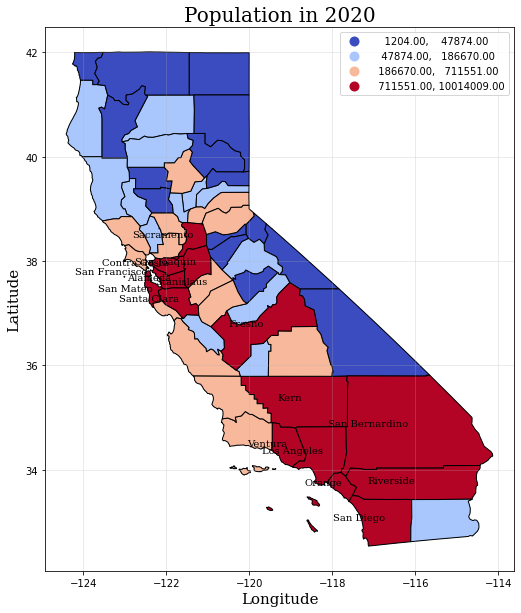

In [31]:
# Plot the population data
plot_one_data(pop_plot)

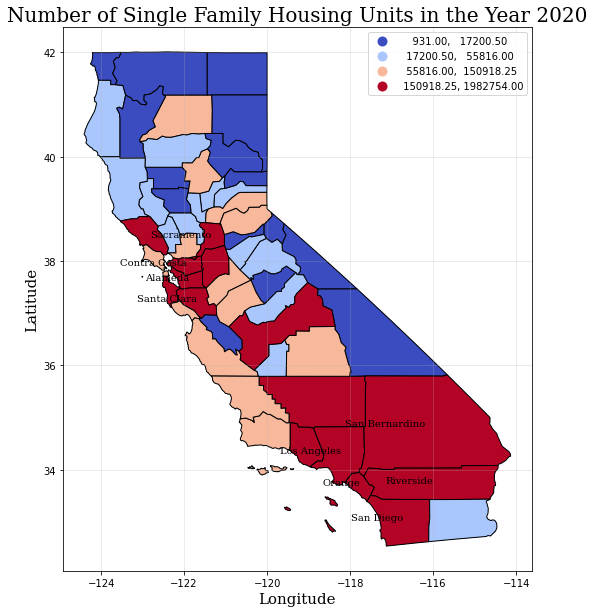

In [32]:
# Plot the housing units data
plot_one_data(housing_plot)

In [33]:
# Some counties have high median home price but fewer housing units while others have lower median price but more units
# To understand the total single family property financial exposure a county has to natural hazards,
# multiply the # of housing units in a county by median home price.
# Note that this is approximate because the latest single family housing units data is from 2020 and median home price data is from 2024
# but number of housing units have not increased significantly in last few years so this is OK.
ca_county["total single family property worth"] = ca_county["single family units"] * ca_county["home price"]
ca_county.head()

,geometry,home price,population,single family units,total single family property worth
county,,,,,
Amador,"POLYGON ((-120.99550 38.22541, -121.02708 38.3...",433208.333333,40474,16084,6.967723e+09
Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7...",352187.500000,28917,7959,2.803060e+09
Lake,"POLYGON ((-122.62740 38.66751, -122.82159 38.8...",339725.000000,68163,23926,8.128260e+09
Mariposa,"POLYGON ((-120.38767 37.63336, -120.38733 37.6...",437333.333333,17131,6834,2.988736e+09
Napa,"POLYGON ((-122.10328 38.51335, -122.08884 38.3...",936500.000000,138019,40831,3.823823e+10


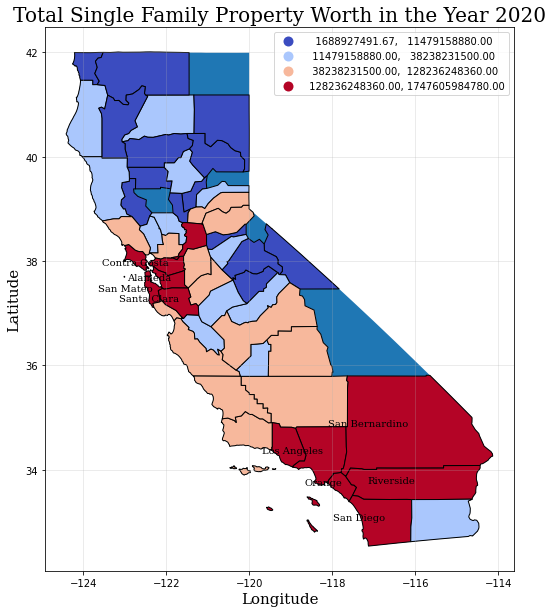

In [34]:
exposure_plot = {"col" : "total single family property worth", 
                "title" : "Total Single Family Property Worth in the Year " + str(latest_housing_year), "threshold" : 300000 * 900000}
plot_one_data(exposure_plot)

**<font color="purple"> <font size = 3> The line plots show that population and number of single family housing units in most California counties has steadily increased from 1990 to 2020. The population of California state as a whole has increased from around 30 million in 1990 to around 39 million in 2020 while the number of single family units has increased from around 7 million in 1990 to around 10 million in 2020.
The choropleth map uses "quantiles" scheme with number of bins (k) set to 4. Note the counties with red color are in the upper quartile. We will compare these maps with the map of FEMA natural hazard risk index score later in the notebook. </font>**
    
***

<a id='fema'></a>
### <font color="blue">FEMA Natural Hazard Risk Index for California Counties</font>

#### <font color="purple"> Dataset: FEMA's Natural Hazard Risk Index for California Counties was downloaded from the link [here](https://hazards.fema.gov/nri/data-resources#csvDownload)</font>

* The National Risk Index provides relative risk score percentiles based on data for Expected Annual Loss due to natural hazards, Social Vulnerability, and Community Resilience.
* The dataset contains a composite risk score for all hazards and also individual risk scores for 18 types of natural hazards such as earthquakes, tornadoes, hurricanes and so on.
* A county's risk score is represented by its percentile ranking among all other counties at the same level for Risk, Expected Annual Loss, Social Vulnerability and Community Resilience. For example, if a given county's risk score percentile for a hazard type is 84.32 then its risk score value is greater than 84.32% of all US counties.
* More information about this dataset is available [here](https://hazards.fema.gov/nri/understanding-scores-ratings).
* **<font color="purple">This project uses the composite risk score for California Counties.</font>**

***

In [35]:
# Read the FEMA natural hazard risk index dataset
ca_risk = pd.read_csv("../datasets/fema/NRI_Table_Counties_California/NRI_Table_Counties_California.csv")
ca_risk.head(2)

,OID_,NRI_ID,STATE,STATEABBRV,STATEFIPS,COUNTY,COUNTYTYPE,COUNTYFIPS,STCOFIPS,POPULATION,...,WNTW_EALS,WNTW_EALR,WNTW_ALRB,WNTW_ALRP,WNTW_ALRA,WNTW_ALR_NPCTL,WNTW_RISKV,WNTW_RISKS,WNTW_RISKR,NRI_VER
0,188,C06001,California,CA,6,Alameda,County,1,6001,1678284,...,4.302074,Very Low,0.000000,0.000000,0.000000e+00,4.271123,0.000751,1.622654,Very Low,March 2023
1,189,C06003,California,CA,6,Alpine,County,3,6003,1198,...,69.730734,Relatively Moderate,0.000004,0.000007,3.838500e-11,99.257196,144225.447575,72.955775,Relatively Moderate,March 2023


In [36]:
# Keep only the columns of interest
ca_risk = ca_risk[["COUNTY", "RISK_SCORE"]]
ca_risk.columns = ["county", "risk score"]
ca_risk.set_index("county", inplace = True)
ca_risk.head()

,risk score
county,
Alameda,99.872733
Alpine,23.926185
Amador,77.791919
Butte,97.168311
Calaveras,86.446071


In [37]:
# Add the risk score column to the ca_county dataframe
ca_county["risk score"] = ca_risk["risk score"]
ca_county.head()

,geometry,home price,population,single family units,total single family property worth,risk score
county,,,,,,
Amador,"POLYGON ((-120.99550 38.22541, -121.02708 38.3...",433208.333333,40474,16084,6.967723e+09,77.791919
Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7...",352187.500000,28917,7959,2.803060e+09,94.813872
Lake,"POLYGON ((-122.62740 38.66751, -122.82159 38.8...",339725.000000,68163,23926,8.128260e+09,91.918549
Mariposa,"POLYGON ((-120.38767 37.63336, -120.38733 37.6...",437333.333333,17131,6834,2.988736e+09,79.860006
Napa,"POLYGON ((-122.10328 38.51335, -122.08884 38.3...",936500.000000,138019,40831,3.823823e+10,97.677378


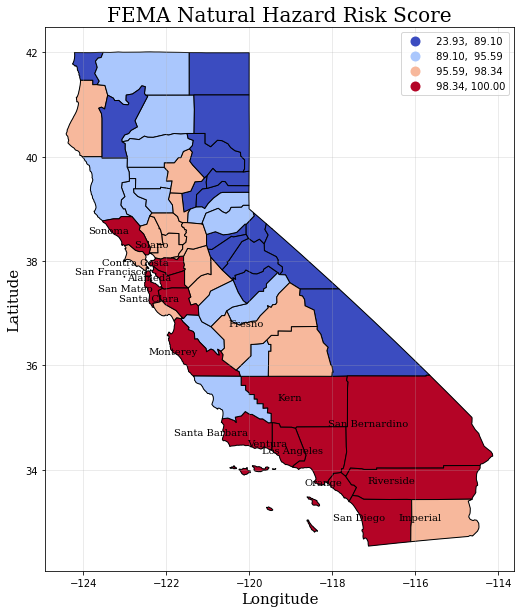

In [38]:
# Set the threshold so that the names of the counties with risk index over 98 are displayed
risk_plot = {"col" : "risk score", "title" : "FEMA Natural Hazard Risk Score", "threshold" : 98}
plot_one_data(risk_plot)

In [39]:
# Note that the risk scrore is a US wide percentile.
# Above plot indicates that most CA counties have very high risk score when compared to the ones in rest of the US

print("Total number of counties in California:", len(ca_county))
print("Number of counties in California with risk index greatern than 75% of all US Counties:", 
      len(ca_county[ca_county["risk score"] > 75]))

Total number of counties in California: 58
Number of counties in California with risk index greatern than 75% of all US Counties: 54


**<font color="purple"> <font size = 3> The choropleth map uses "quantiles" scheme with number of bins (k) set to 4. But note that most CA counties have a very high risk score when compared to that of all US counties. 54 of total 58 California counties have a risk score greater than 75% of all US counties. </font>**

***

<a id='spatial'></a>
### <font color="blue"> Spatial Analysis of Population, Housing and FEMA Risk Index

#### <font color="purple">Are areas with high housing costs also the areas at higher risks from natural disasters? </font>
To answer this question, plot home price and risk score side by side for quick spatial comparison. 

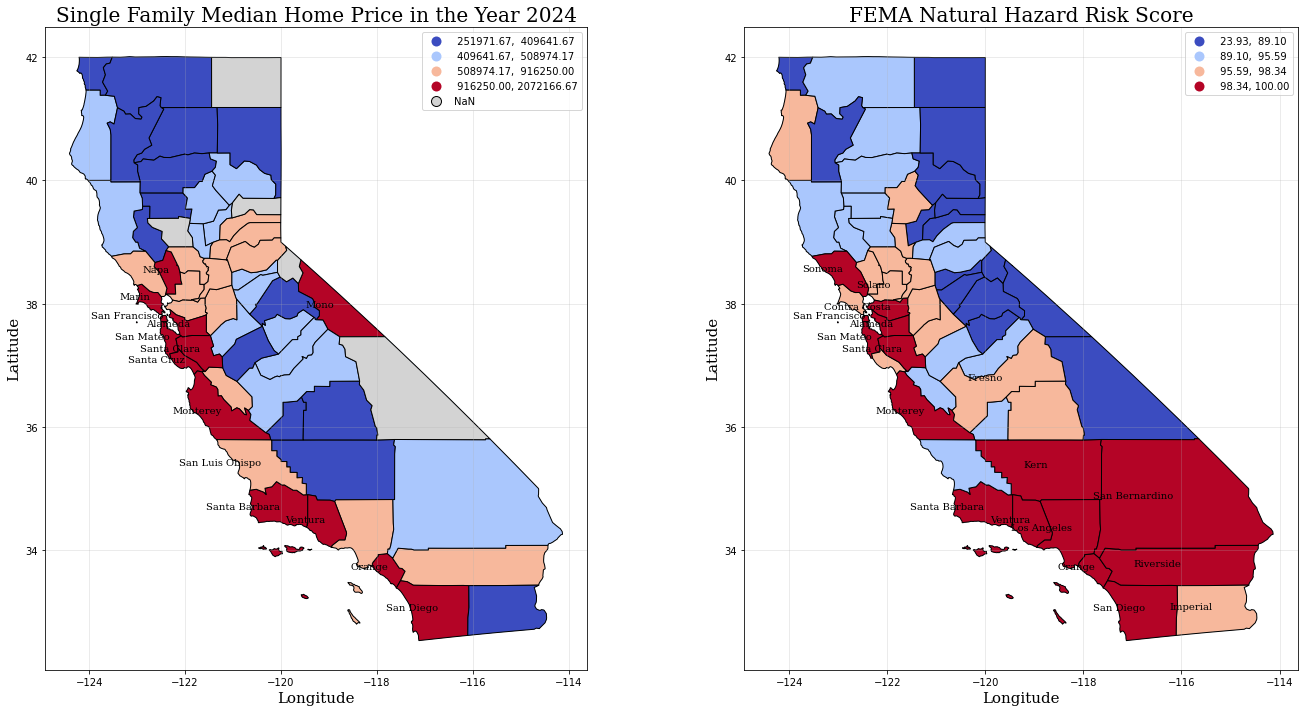

In [40]:
plot_many_data([price_plot, risk_plot])

**<font color="purple"> <font size = 3>Above two choropleth maps use "quantiles" scheme with number of bins (k) set to 4. Counties in red are in the upper quartile. There is some overlap between the counties with high price of single family homes and counties that have high natural hazard risk score e.g. Santa Clara county. But there are some counties e.g. the Kern county where the home prices are low but at the high risk of natural hazards. Infact  most CA counties have a very high risk score when compared to that of all US counties. 54 of total 58 California counties have a risk score greater than 75% of all US counties. </font>**

***

#### <font color="purple">Are areas with higher population also the areas at higher risks from natural disasters? </font>
To answer this question, plot population and risk score side by side for quick spatial comparison. 

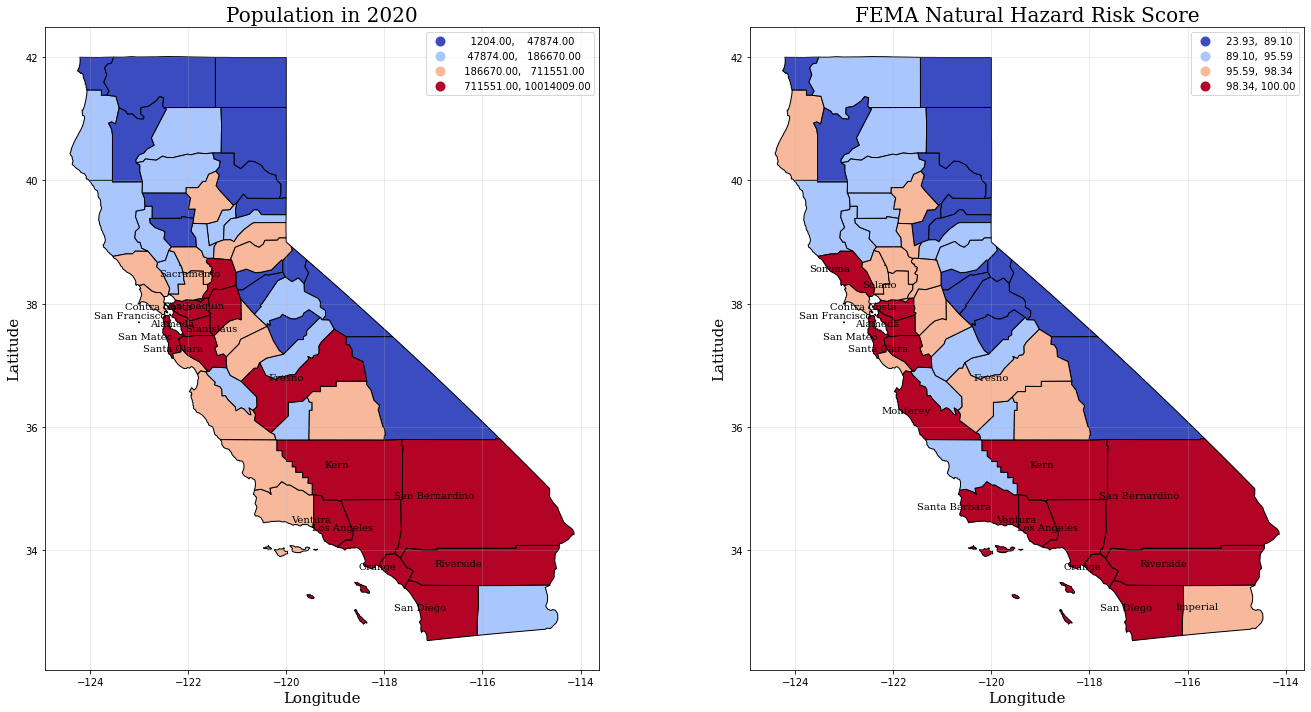

In [41]:
plot_many_data([pop_plot, risk_plot])

**<font color="purple"> <font size = 3>Above two choropleth maps use "quantiles" scheme with number of bins (k) set to 4. Counties in red are in the upper quartile. There is quite a bit overlap between the counties with higher population and counties that have high natural hazard risk score e.g. Santa Clara county. But most CA counties have a very high risk score when compared to that of all US counties. 54 of total 58 California counties have a risk score greater than 75% of all US counties. </font>**

***

#### <font color="purple">Are areas with higher number of single family homes also the areas at higher risks from natural disasters? </font>
To answer this question, plot number of single family housing units and risk score side by side for quick spatial comparison. 

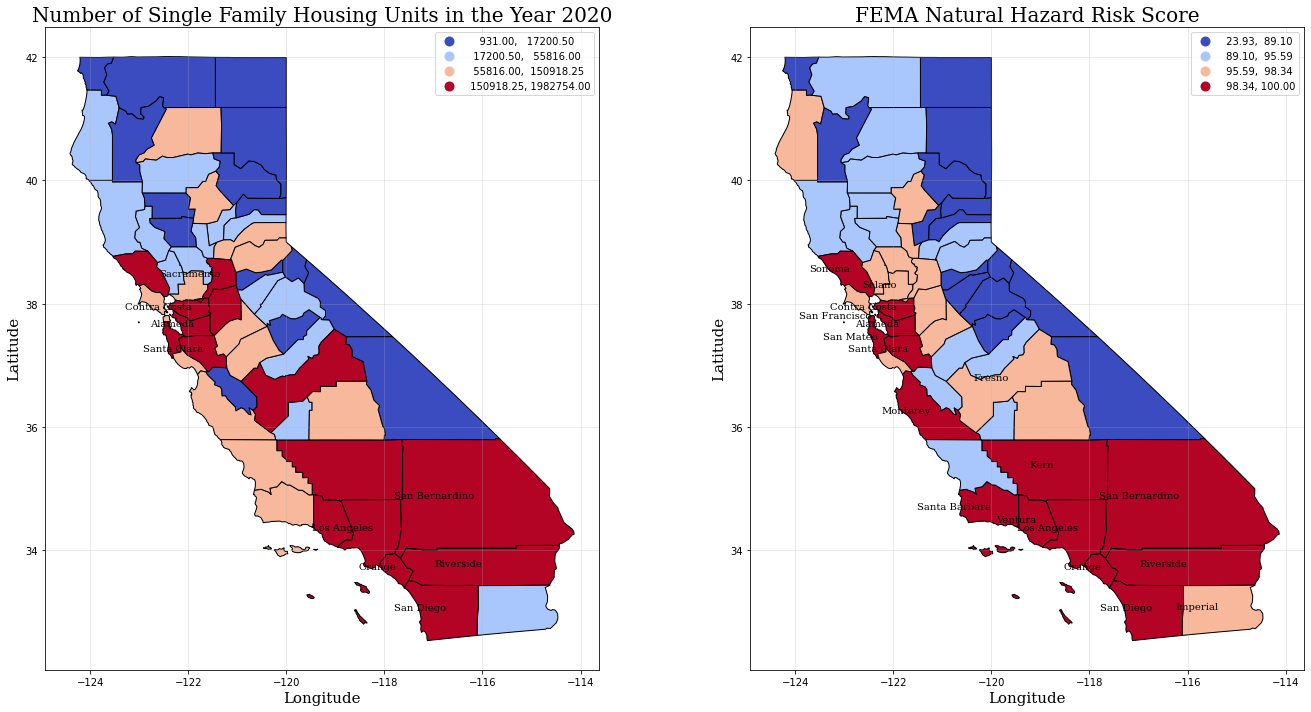

In [42]:
plot_many_data([housing_plot, risk_plot])

**<font color="purple"> <font size = 3>Above two choropleth maps use "quantiles" scheme with number of bins (k) set to 4. Counties in red are in the upper quartile. There is quite a bit overlap between the counties with higher number of single family units and counties that have high natural hazard risk score e.g. Santa Clara county. But most CA counties have a very high risk score when compared to that of all US counties. 54 of total 58 California counties have a risk score greater than 75% of all US counties. </font>**

***

#### <font color="purple">Are areas with higher total single family property values also the areas at higher risks from natural disasters? </font>
Note as mentioned earlier, some counties have high median single family home price but fewer single family housing units while others have lower median price but more units. To understand the total single family property financial exposure a county has to natural hazards, the number of single family housing units in a county was multiplied by the median single family home price in the county.

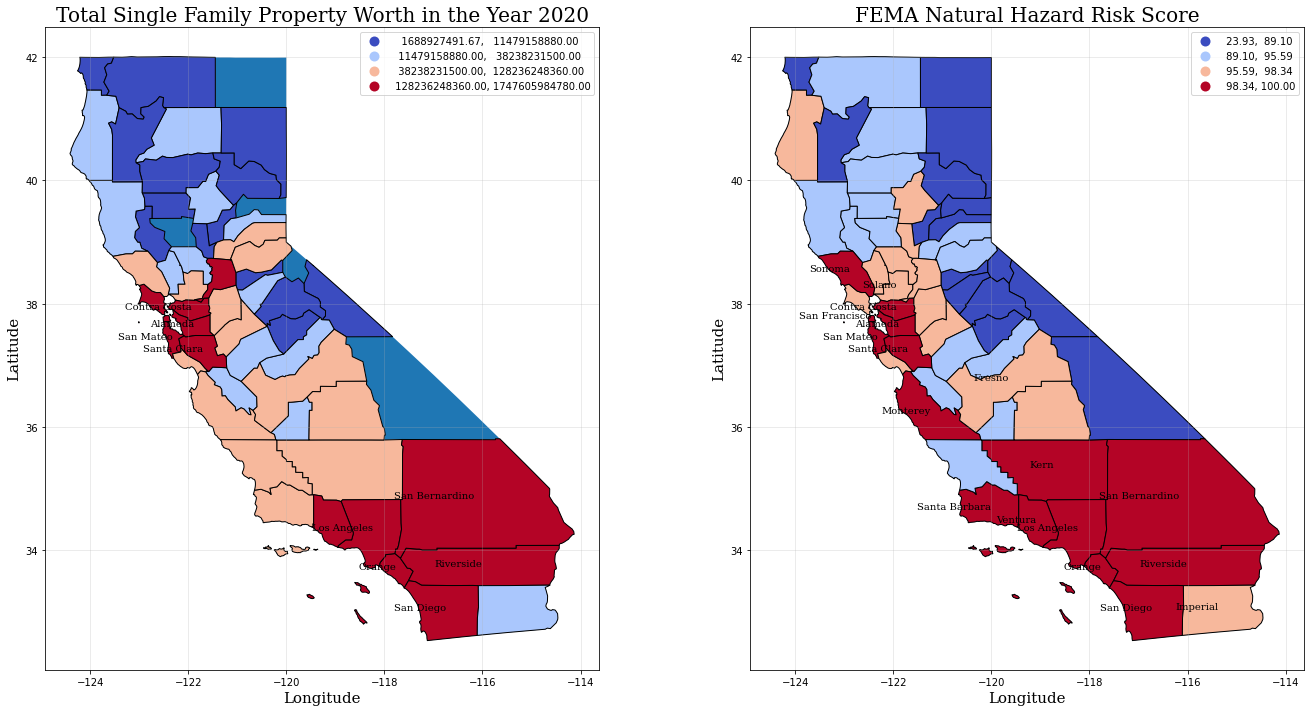

In [43]:
plot_many_data([exposure_plot, risk_plot])

**<font color="purple"> <font size = 3>Above two choropleth maps use "quantiles" scheme with number of bins (k) set to 4. Counties in red are in the upper quartile. There is some overlap between the counties with higher total single family property worth  and counties that have high natural hazard risk score e.g. Santa Clara county. But most CA counties have a very high risk score when compared to that of all US counties. 54 of total 58 California counties have a risk score greater than 75% of all US counties. </font>**

***

<a id='stats'></a>
### <font color="purple">Statistical Analysis: Correlation between the home price, population, housing units and risk score </font>

In [44]:
# Use the Spearman rank correlation due to some no-linear relationship in the data
ca_corr = ca_county.corr(method="spearman")
ca_corr

,home price,population,single family units,total single family property worth,risk score
home price,1.000000,0.557491,0.576923,0.749960,0.562974
population,0.557491,1.000000,0.991941,0.956297,0.898859
single family units,0.576923,0.991941,1.000000,0.963796,0.876157
total single family property worth,0.749960,0.956297,0.963796,1.000000,0.876391
risk score,0.562974,0.898859,0.876157,0.876391,1.000000


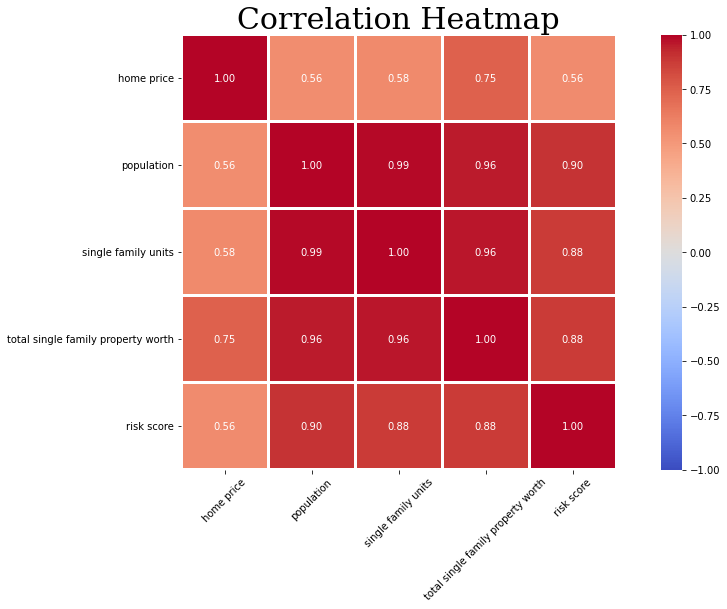

In [45]:
fig, ax = plt.subplots(figsize=(16, 8))
sb.heatmap(ca_corr, annot=True, fmt=".2f",  cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidth=2)
plt.title("Correlation Heatmap", fontsize=30, family="serif")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=45);

- <font color="purple"><font size=4>The heatmap shows strong correlation between the risk score and other features such as population, number of single family units and total worth of single family property. Since FEMA calculates the risk score based on factors such as expected annual loss due to hazards, this correlation is expected. </font>
- <font color="purple"><font size=4>However without a hypothesis test, we cannot say whether these correlations are statistically significant. Such a test is beyond the scope of this project. </font>

***

<a id='part2'></a>
## <font color="blue">Part-2: Explore a What-If Scenario. </font>
The last major earthquake in the San Francisco (SF) Bay Area was the Loma Prieta Earthquake in 1989. *What-if Loma Prieta earthquake were to happen today?*

Part-2 of this project predicts the number of single family housing units that may be damaged/destroyed and estimates associated financial costs as a result of it.

***

### <font color="purple">Plot Shake Map of Loma Prieta Earthquake. </font>
According to [USGS](https://earthquake.usgs.gov/data/shakemap/), *shakeMaps provide near-real-time maps of ground motion and shaking intensity following significant earthquakes. These maps are used by federal, state, and local organizations, both public and private, for post-earthquake response and recovery, public and scientific information, as well as for preparedness exercises and disaster planning.*

**Dataset: The shape file for the Loma Preita Earthquake Shake Map was downloaded from USGS Shapefile link below:**
- [Metadata](https://earthquake.usgs.gov/earthquakes/eventpage/nc216859/shakemap/metadata)
- [Shapefile](https://earthquake.usgs.gov/product/shakemap/nc216859/atlas/1594161215615/download/shape.zip)

In [46]:
eq_map = gpd.read_file(os.path.join(r'zip:///home/jovyan/work/courseProject/datasets/earthquake/shape.zip'))
eq_map.head(3)

,AREA,PERIMETER,PGAPOL_,PGAPOL_ID,GRID_CODE,PARAMVALUE,geometry
0,0.0,0.0,12,12,0,2.4,"POLYGON ((-118.15222 34.15000, -118.15997 34.1..."
1,0.0,0.0,13,13,0,2.6,"MULTIPOLYGON (((-116.66135 40.88333, -116.6621..."
2,0.0,0.0,14,14,0,2.8,"MULTIPOLYGON (((-117.48296 40.88333, -117.4830..."


#### Shake intensity legend obtained from USGS link [here](https://earthquake.usgs.gov/earthquakes/eventpage/nc216859/shakemap/intensity)
![USGS Earthquake Shake Intensity Legend](../datasets/earthquake/usgs_shake_intensity_legend.png)

In [47]:
# Based on the above USGS Shake intensity scale, damage from areas with lower shaking/intensity less than 5 is negligible
# Filter out areas with low intensity
eq_map.rename(columns={"PARAMVALUE": "intensity"}, inplace=True)
eq_map = eq_map[eq_map["intensity"] >= 5]
eq_map.reset_index(inplace=True)
eq_map = eq_map[["intensity", "geometry"]]
eq_map.head(3)

,intensity,geometry
0,5.0,"MULTIPOLYGON (((-122.56115 38.23333, -122.5615..."
1,5.2,"MULTIPOLYGON (((-122.54123 38.21667, -122.5445..."
2,5.4,"MULTIPOLYGON (((-122.53682 38.21667, -122.5417..."


In [48]:
# county is an index, make it also a column
ca_county.reset_index(inplace = True)
ca_county.head(3)

,county,geometry,home price,population,single family units,total single family property worth,risk score
0,Amador,"POLYGON ((-120.99550 38.22541, -121.02708 38.3...",433208.333333,40474,16084,6.967723e+09,77.791919
1,Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7...",352187.500000,28917,7959,2.803060e+09,94.813872
2,Lake,"POLYGON ((-122.62740 38.66751, -122.82159 38.8...",339725.000000,68163,23926,8.128260e+09,91.918549


In [49]:
# Find the gemoteric intersection between the earthquake intensity shake (countour) map and ca_county dataframes
ca_map = gpd.overlay(ca_county, eq_map, how='intersection')
ca_map.head()

,county,home price,population,single family units,total single family property worth,risk score,intensity,geometry
0,Napa,936500.000000,138019,40831,3.823823e+10,97.677378,5.0,"MULTIPOLYGON (((-122.09675 38.31587, -122.1032..."
1,Stanislaus,474729.166667,552878,145105,6.888558e+10,95.800191,5.0,"MULTIPOLYGON (((-121.36664 37.35000, -121.3666..."
2,San Benito,803500.000000,64209,16853,1.354139e+10,93.859370,5.0,"MULTIPOLYGON (((-120.71667 36.44959, -120.7170..."
3,Solano,591966.666667,453491,123997,7.340209e+10,98.218263,5.0,"MULTIPOLYGON (((-122.11536 38.11667, -122.1154..."
4,Contra Costa,879975.000000,1165927,315896,2.779806e+11,99.586382,5.0,"MULTIPOLYGON (((-121.62976 37.85000, -121.6314..."


**Verify all layers of the data we are plotting in the next plot are in the same coordinate reference system.**

In [50]:
ca_county.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [51]:
ca_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

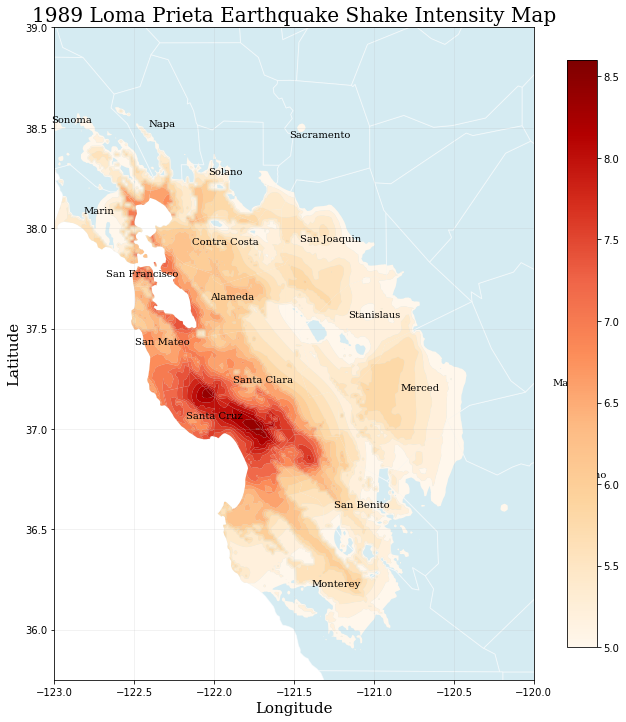

In [52]:
# Subset ca_county to keep only the counties affected by Loma Prieta Earthquake
ca_county_subset = ca_county[ca_county['county'].isin(list(ca_map["county"].unique()))]
ca_county_subset.reset_index(inplace=True)
ca_county_subset.drop(columns=["index"], inplace=True)

# Plot the eartquake shake map
fig, ax = plt.subplots(figsize=(12,12))
plt.title("1989 Loma Prieta Earthquake Shake Intensity Map", fontsize=20, family="serif")
ax.set_xlim(-123, -120)  # Longitude range
ax.set_ylim(35.75, 39)    # Latitude range
ax.set_xlabel("Longitude", fontsize=15, family="serif")
ax.set_ylabel("Latitude", fontsize=15, family="serif")
plt.grid(True, alpha=0.2)
ca_county.plot(ax=ax, facecolor="lightblue", edgecolor="white", alpha=0.5)
ca_map.plot(ax=ax, column="intensity", cmap="OrRd", legend=True, legend_kwds={"shrink":0.9}, linewidth=1.5, facecolor="blue")
ca_county_subset.apply(lambda row: ax.text(row["geometry"].centroid.coords[0][0], row["geometry"].centroid.coords[0][1], row["county"],
                        fontsize=10, ha='center', color='black', family="serif"), axis=1)
plt.show();

**<font color="purple"> <font size = 3> Above shake map shows that several counties in the San Francisco Bay Area experienced moderate (5) to extreme (8.5) shaking during the Loma Prieta Earthquake in 1989. </font>**

In [53]:
# Subset of CA counties affected by Loma Prieta
ca_county_subset

,county,geometry,home price,population,single family units,total single family property worth,risk score
0,Napa,"POLYGON ((-122.10328 38.51335, -122.08884 38.3...",9.365000e+05,138019,40831,3.823823e+10,97.677378
1,Stanislaus,"POLYGON ((-120.93137 37.42175, -120.96422 37.3...",4.747292e+05,552878,145105,6.888558e+10,95.800191
2,San Benito,"POLYGON ((-121.58135 36.89915, -121.50149 36.9...",8.035000e+05,64209,16853,1.354139e+10,93.859370
3,San Francisco,"MULTIPOLYGON (((-122.41870 37.85272, -122.4344...",1.636375e+06,873965,128398,2.101073e+11,98.918231
4,San Mateo,"POLYGON ((-122.29297 37.10732, -122.30614 37.1...",2.072167e+06,764442,184572,3.824639e+11,99.331849
5,Santa Cruz,"POLYGON ((-122.01597 37.16566, -121.75760 37.0...",1.312750e+06,270861,77013,1.010988e+11,97.613745
6,Solano,"POLYGON ((-122.08884 38.38415, -122.10328 38.5...",5.919667e+05,453491,123997,7.340209e+10,98.218263
7,Contra Costa,"POLYGON ((-121.91014 37.73046, -121.96077 37.7...",8.799750e+05,1165927,315896,2.779806e+11,99.586382
8,Madera,"POLYGON ((-119.73385 36.94856, -119.82342 36.8...",4.318958e+05,156255,40572,1.752288e+10,94.654788
9,Merced,"POLYGON ((-120.93137 37.42175, -120.38767 37.6...",4.061333e+05,281202,67425,2.738354e+10,95.322940


### <font color="blue"> Estimate financial loss in single family home damages if the Loma Prieta Earthquake were to happen today. </font>

According to [this Public Policy Institute of California document](https://www.ppic.org/wp-content/uploads/content/pubs/jtf/JTF_EarthquakeRecoveryJTF.pdf), after the 1989 Loma Prieta earthquake, approximately $570 million was paid in 45,000 insurance claims on single-family residences (65% of all insurance claims related to the earthquake).

In [54]:
# Based on the numbers in the above mentioned document, what was the amount paid in single family homes insurance claims due to 
# damage cause by the Loma Prieta earthquake?
eq_insurance_claims = int((570000000 * 65)/100)
eq_insurance_claims

370500000

In [55]:
# According to Federal Reserve Bank https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator,
# $1 in 1989 is equivalent to $2.54 today/ end of 2024
eq_insurance_claims_in_todays_dollars = eq_insurance_claims * 2.54
print("Loma Prieta Single Family Homes Insurance Claims in today's Dollar", f"${eq_insurance_claims_in_todays_dollars:,.2f}")

Loma Prieta Single Family Homes Insurance Claims in today's Dollar $941,070,000.00


In [56]:
# Based on the numbers in the above mentioned document, how many single family homes were damaged by the Loma Prieta Earthquake?
eq_housing_90_damage = int((45000 * 65)/100)
eq_housing_90_damage

29250

In [57]:
# What was the total number of single family units in 1990 in the counties affected by the Loma Prieta Earthquake?
eq_housing_90_total = ca_housing_90[list(ca_county_subset["county"].unique())].iloc[0,:].sum()
eq_housing_90_total

2324429

In [58]:
# What % of total single family homes were damagaed by the Loma Prieta Earthquake?
eq_housing_damage_percent = round((eq_housing_90_damage * 100)/eq_housing_90_total, 2)
eq_housing_damage_percent

1.26

In [59]:
# How many total single family units currently in the counties affected by the Loma Prieta Earthquake?
eq_housing_today = ca_county_subset["single family units"].sum()
eq_housing_today

3130262

In [60]:
# Assuming if Loma Preieta were to happen today and same % of single family units are damaged, estimate the number
# single family homes likely to be damagaed.
eq_num_housing_damage_estimate_today = int((eq_housing_today * eq_housing_damage_percent)/100)
print("Estimate for the number of Single Family Homes likely to be damaged if the Loma Prieta Earthquake were to happen today", 
      eq_num_housing_damage_estimate_today)

Estimate for the number of Single Family Homes likely to be damaged if the Loma Prieta Earthquake were to happen today 39441


In [61]:
# What is the average median price of single family homes today in the counties affected by Loma Prieta?
eq_avg_housing_price_today = ca_county_subset["home price"].mean()
eq_avg_housing_price_today

984488.6574074073

In [62]:
# Worst case estimate - if all the damaged homes are completely destroyed
eq_financial_est_today = int(eq_avg_housing_price_today * eq_num_housing_damage_estimate_today)
print("Estimate for financial loss if the all damaged single family homes are completely destroyed", 
      f"${eq_financial_est_today:,.2f}")

Estimate for financial loss if the all damaged single family homes are completely destroyed $38,829,217,136.00


In [63]:
# Estimate - if 50% of the damaged homes are completely destroyed or need significant repairs
eq_financial_est_today = int(eq_avg_housing_price_today * eq_num_housing_damage_estimate_today * 0.5)
print("Estimate for financial loss if 50% of the damaged homes are completely destroyed or need significant repairs", 
      f"${eq_financial_est_today:,.2f}")

Estimate for financial loss if 50% of the damaged homes are completely destroyed or need significant repairs $19,414,608,568.00


In [64]:
# Estimate - if 10% of the damaged homes are completely destroyed or need significant repairs
eq_financial_est_today = int(eq_avg_housing_price_today * eq_num_housing_damage_estimate_today * 0.1)
print("Estimate for financial loss if 10% of the damaged homes are completely destroyed or need significant repairs", 
      f"${eq_financial_est_today:,.2f}")

Estimate for financial loss if 10% of the damaged homes are completely destroyed or need significant repairs $3,882,921,713.00


In [65]:
# Compare above estimates to actual claims paid by the insurance industry in today's dollars
print("Loma Prieta Single Family Homes Insurance Claims in today's Dollar", f"${eq_insurance_claims_in_todays_dollars:,.2f}")

Loma Prieta Single Family Homes Insurance Claims in today's Dollar $941,070,000.00



- <font color="purple"><font size=4>Above calculations show that the insurance industry paid almost $1 billion (in today's USD) in single family resident claims due to damages during the Loma Prieta Earthquake in 1989.
- <font color="purple"><font size=4>Around 1.26% of total single family housing units were damaged or destroyed due to the earthquake in 1989. We assume that the same percentage, i.e. 1.26%, of the total single family homes will be affected if the earthquake occurs today. Using this % and total number of single family housing units in 2020,  around 39441 single family homes are likely to be affected if the earthquake occurs today.
- <font color="purple"><font size=4>It is not possible to predict exactly the level of damage to the single family homes if the earthquake occurs today - some single family homes may be completely destroyed while others may be damaged partially. Above calculations provide three estimates based on percentage of damaged homes that may be completely destroyed or need significant repairs. The estimates range from \\$40 billion (worst case) to \\$4 billion USD in financial loss or insurance claims. </font>


***

<a id='conclusion'></a>
## <font color="blue">Conclusion </font>
***

- <font color="purple"><font size=4>The plots show that population, number of single family housing units and median price of single family homes has steadily increased across California from 1990 to present. The population of California state as a whole has increased from around 30 million in 1990 to around 39 million in 2020, the number of single family units has increased from around 7 million in 1990 to around 10 million in 2020 while the median price of single family homes has increased from \\$200,000 in 1990 to around \\$850,000 in 2024. </font>
- <font color="purple"><font size=4>Out of total 58 California counties, 54 have FEMA's natural hazard risk score greater than 75% of all US counties.</font>
- <font color="purple"><font size=4>The heatmap and spatial maps suggest areas with higher population and higher single family housing units are also the areas at higher risk from natural hazards. There is a strong correlation between the risk score and other features such as population, number of single family units and total worth of single family property. Since FEMA calculates the risk score based on factors such as expected annual loss due to hazards, this correlation may be expected. However without a hypothesis test, we cannot say whether these correlations are statistically significant. Such a test is beyond the scope of this project. </font>
- <font color="purple"><font size=4>Calculations in Part-2 estimate almost 40,000 single family housing units may be potentially damaged or destoryed if the Loma Prieta earthquake were to occur today resulting in loss of anywhere between \\$4 billion to \\$40 billion based on the level of damage.</font>